In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dtaidistance import dtw


data_C = pd.read_csv('./data/all_C_signals2.txt',sep=" ",header=None)
data_A = pd.read_csv('./data/all_A_signals1.txt',sep=" ",header=None)
data_G = pd.read_csv('./data/all_G_signals1.txt',sep=" ",header=None)
data_T = pd.read_csv('./data/all_T_signals1.txt',sep=" ",header=None)


data_C.columns = [1,2,'kmer',4,5,'values']
data_C = data_C[['kmer','values']]

data_G.columns = [1,2,'kmer',4,5,'values']
data_G = data_G[['kmer','values']]

data_A.columns = [1,2,'kmer',4,5,'values']
data_A = data_A[['kmer','values']]

data_T.columns = [1,2,'kmer',4,5,'values']
data_T = data_T[['kmer','values']]

data = pd.concat([data_C,data_A,data_G,data_T])
data = data.reset_index()

#print("There are "+str(len(data['kmer'].unique()))+" unique kmers")
#print("data dimension: "+str(data.shape))
data_C.sort_values('kmer').head()

kmer                                             values
2740  AACAA  852_868_862_863_902_855_858_840_821_869_814_84...
105   AACAA  740_740_747_722_745_751_770_776_749_734_605_58...
1956  AACAA  726_734_781_778_775_733_726_760_693_608_573_55...
3134  AACAA  673_570_536_539_580_531_542_530_546_555_533_55...
40    AACAA  836_868_854_818_812_809_809_835_820_827_812_78...

In [2]:
data_subset = data_C
print("There are "+str(len(data_subset['kmer'].unique()))+" unique kmers")
print("data dimension: "+str(data_subset.shape))
data_subset.head()

There are 256 unique kmers
data dimension: (3743, 2)


kmer                                             values
0  AGCTT  591_571_586_587_600_586_582_586_576_582_585_58...
1  ACCAC  569_564_567_570_556_577_595_594_619_637_581_56...
2  GTCAC  570_536_515_503_520_527_531_529_531_540_531_53...
3  GACAC  561_552_562_515_542_532_533_573_519_559_573_55...
4  ATCTT  756_751_744_753_784_732_795_794_792_767_785_78...

In [32]:
freq = data_subset['kmer'].value_counts(ascending=False).sort_index()
freq.sort_values().tail(10)
#freq.head()

AACTG    33
TCCAT    33
ACCCA    33
ATCCA    33
TCCTG    33
ACCAA    34
ACCTG    36
TTCCA    37
ATCAA    44
TGCTG    48
Name: kmer, dtype: int64

In [32]:
import re

r = re.compile('AACA.')
all_kmer = list(freq.index)
chosen_kmer = list(filter(r.match, all_kmer))
data_subset = data_subset.loc[data_subset['kmer'].isin(chosen_kmer),:]

print(data_subset.shape)
data_subset.head()

(64, 2)


kmer                                             values
40   AACAA  836_868_854_818_812_809_809_835_820_827_812_78...
105  AACAA  740_740_747_722_745_751_770_776_749_734_605_58...
109  AACAG  715_735_788_731_859_793_684_745_766_806_742_82...
156  AACAA  756_801_782_802_829_830_792_803_810_834_818_81...
169  AACAC  535_554_541_537_549_549_527_552_543_551_534_53...

In [6]:
series_subset = []
for i in data_subset.index:
    val = map(int,data_subset.loc[i,'values'].split("_"))
    series_subset.append(np.array(list(val), dtype=np.double))
    
ds_subset = dtw.distance_matrix_fast(series_subset,show_progress=True)

/home/ratanond/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


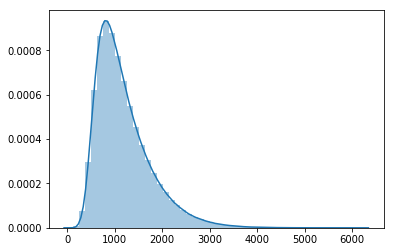

In [7]:
np.fill_diagonal(ds_subset,0)
ds_subset[np.tril_indices(ds_subset.shape[0],k=-1)] = np.nan
x = np.concatenate(ds_subset,axis=None)
x = x[~np.isnan(x)]
sns.distplot(x)

In [8]:
ds_subset[np.tril_indices(ds_subset.shape[0],k=-1)] = ds_subset.T[np.tril_indices(ds_subset.shape[0],k=-1)]
np.fill_diagonal(ds_subset,0)

ds_subset = pd.DataFrame(ds_subset)
ds_subset.columns = data_subset.index
ds_subset['index'] = data_subset.index
ds_subset = ds_subset.set_index('index')

/home/ratanond/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/ratanond/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


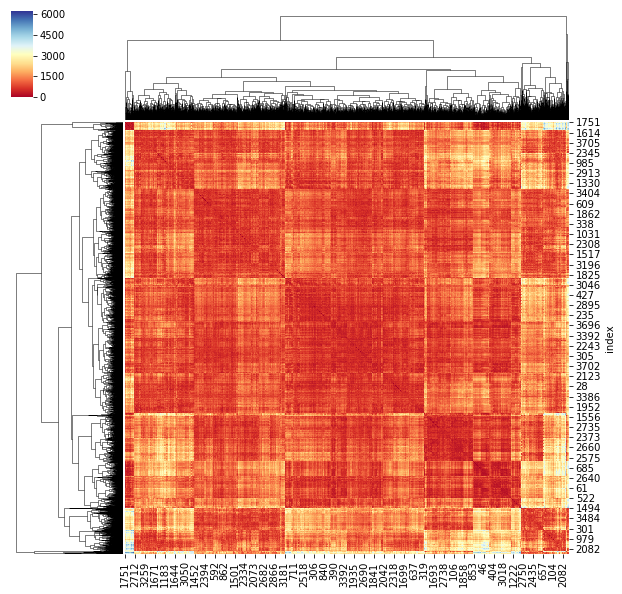

In [9]:
    
#ds_subset_sqrt = np.sqrt(ds_subset)
#ds_subset_squared = np.square(ds_subset)
#ds_subset_log = np.log((np.max(ds_subset.as_matrix())-ds_subset)+1)


clustermap = sns.clustermap(ds_subset, cmap="RdYlBu")

In [26]:
#clustermap.savefig("clustermap_C_89.png")
#clustermap.savefig('clustermap_ATCG_h.png', dpi=1000)

In [15]:
## cluster diagonal matrices

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram


## black lines for separating kmer groups
sep_line_pos = []
j=0
for i in freq:
    j = j+i
    sep_line_pos.append(j)

ds_subset_new = ds_subset

## clustering inorder to get the new row and column orders for the new heatmap
new_order = []
 
i=0
j=0
for k in freq:
  if(k>1):
    j=j+k
    ##if (k>1):
    
    sub_mat = ds_subset_new.iloc[i:j,i:j].as_matrix()
    y = sub_mat[np.triu_indices(sub_mat.shape[0],k=1)]
    row_clusters = linkage(y,method='complete')
    row_dendr = dendrogram(row_clusters,no_plot=True,labels=ds_subset_new.iloc[i:j,i:j].index)
    row_col_number = list(map(int,row_dendr['ivl']))
    new_order = new_order+row_col_number
    #ds_subset_new.iloc[i:j,i:j] = sub_mat[row_col_number].transpose()[row_col_number]
    
    i=j
    
ds_subset_new = ds_subset_new.loc[new_order,new_order]

/home/ratanond/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


/home/ratanond/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


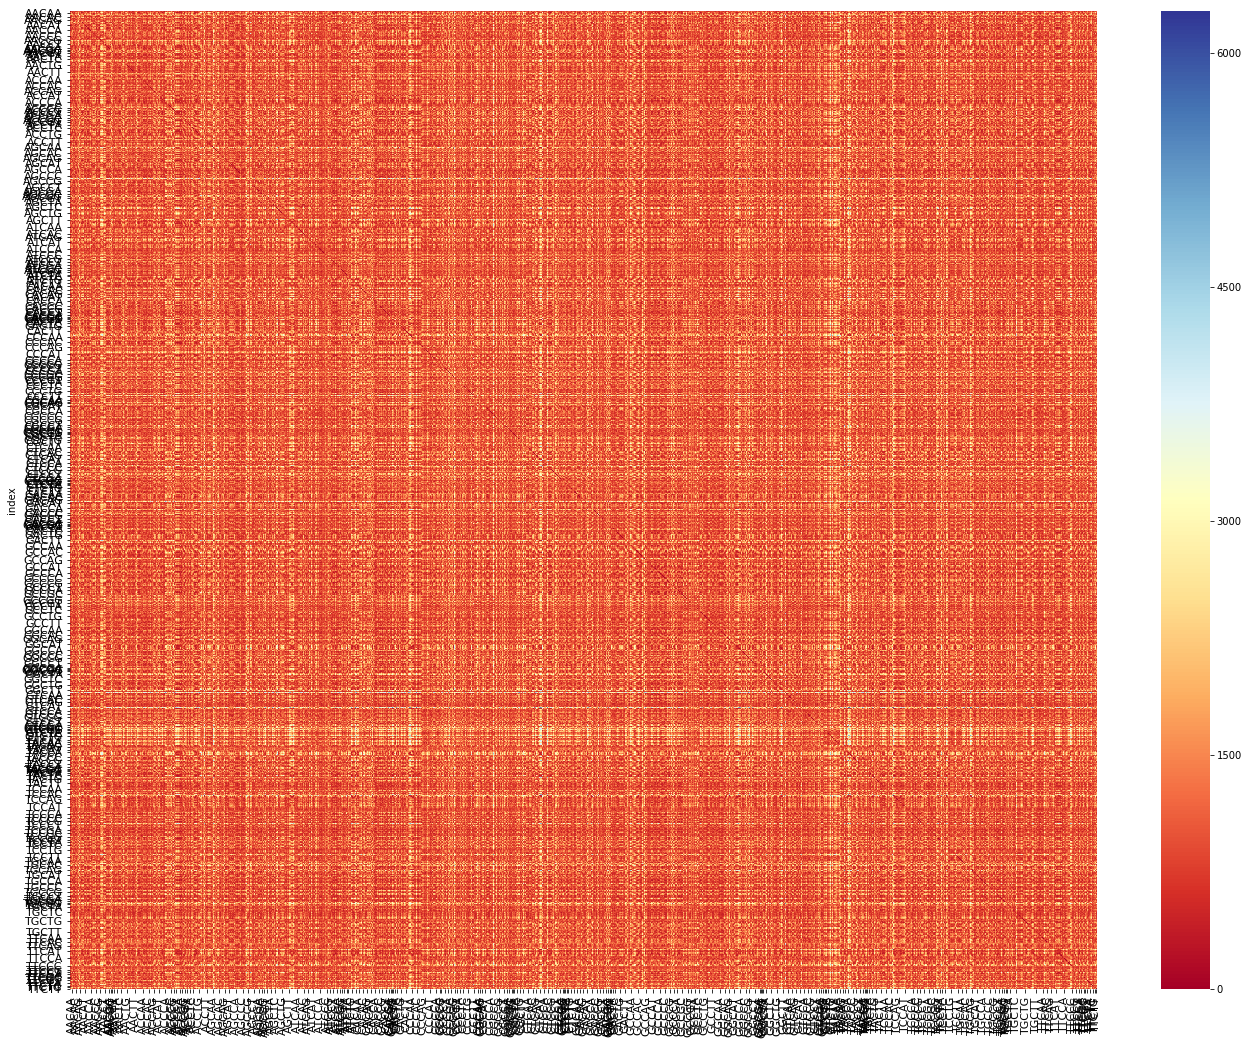

In [28]:
## draw heatmap after clustering


##  transform
ds_subset_new_log = np.log((np.max(ds_subset_new.as_matrix())-ds_subset_new)+1)
ds_subset_new_squared = np.square(ds_subset_new)
ds_subset_new_sqrt = np.sqrt(ds_subset_new)

from matplotlib.ticker import FixedLocator, FixedFormatter

a4_dims = (23, 18)
fig, ax = plt.subplots(figsize=a4_dims)
heatmap_new = sns.heatmap(ds_subset_new, cmap="RdYlBu")
#ax.hlines(sep_line_pos, *ax.get_xlim())
#ax.vlines(sep_line_pos, *ax.get_ylim())

## label by groups (comment all if want to label by each row)
position = []
j=0
for i in freq:
    j=i+j
    position.append((j+j-i)/2)
    
ticks = position 
ticklabels = sorted(list(set(data_subset['kmer'])))

ax.xaxis.set_major_locator(FixedLocator(ticks))
ax.xaxis.set_major_formatter(FixedFormatter(ticklabels))

ax.yaxis.set_major_locator(FixedLocator(ticks))
ax.yaxis.set_major_formatter(FixedFormatter(ticklabels))

plt.tick_params(labelsize=11)

#heatmap_new.get_figure().savefig("heatmap_dcluster_2448.png")

In [130]:
## Verifying one of the kmers

AACTT = data.loc[data['kmer']=='AACTT',:]
AACTT_index = AACTT.index

series_AACTT = []
for i in AACTT_index:
    val = map(int,data.loc[i,'values'].split("_"))
    series_AACTT.append(np.array(list(val)))
    
series = series_AACTT
ds = dtw.distance_matrix(series)
y = ds[np.triu_indices(ds.shape[0],k=1)]

row_clusters = linkage(y,method='complete')

pd.DataFrame(row_clusters,columns=['row label 1','row label 2','distance','no. of items in clust.'],
             index=['cluster %d' %(i+1) for i in range(row_clusters.shape[0])])

row label 1  row label 2    distance  no. of items in clust.
cluster 1           0.0          4.0    0.000000                     2.0
cluster 2           1.0          5.0    0.000000                     2.0
cluster 3           2.0          6.0    0.000000                     2.0
cluster 4           3.0          7.0    0.000000                     2.0
cluster 5           8.0         16.0    0.000000                     3.0
cluster 6           9.0         17.0    0.000000                     3.0
cluster 7          10.0         18.0    0.000000                     3.0
cluster 8          11.0         19.0    0.000000                     3.0
cluster 9          12.0         20.0    0.000000                     4.0
cluster 10         13.0         21.0    0.000000                     4.0
cluster 11         14.0         22.0    0.000000                     4.0
cluster 12         15.0         23.0    0.000000                     4.0
cluster 13         24.0         27.0   64.078077                     8.0
cluster 14         25.0         28.0   84.894052                    12.0
cluster 15         26.0         29.0  965.980331                    16.0

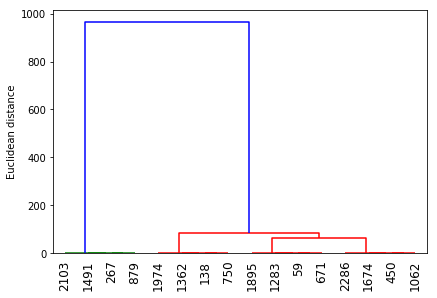

In [131]:
row_dendr = dendrogram(row_clusters, labels = AACTT.index)
plt.tight_layout()
plt.ylabel('Euclidean distance')
plt.xticks(rotation=90)
plt.show()

/home/ratanond/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/ratanond/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


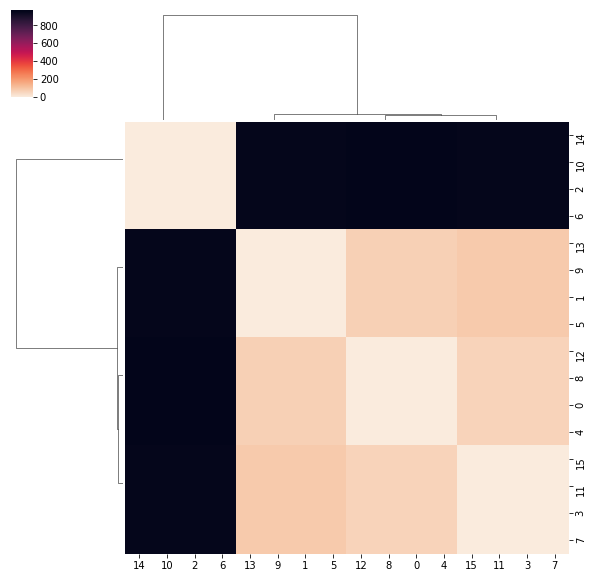

In [132]:
ds[np.tril_indices(ds.shape[0],k=-1)] = ds.T[np.tril_indices(ds.shape[0],k=-1)]
np.fill_diagonal(ds,0)
ds = pd.DataFrame(ds)
g = sns.clustermap(ds,cmap = sns.cm.rocket_r)

In [88]:
data_C.groupby(['values']).count().to_csv('group_by_C.csv')


In [41]:
str(data_C.loc[data_C['values'] == data_C['values'][12]]['kmer'].unique())

"['TCCAT' 'ATCAT' 'ACCAT' 'CCCCA' 'ATCCC']"

In [73]:
df_C = pd.DataFrame(columns=['kmer_list','sequence'])
len_C_unique = len(data_C['values'].unique())
for i in range(0,len_C_unique):
    df_C.loc[i] = str(data_C.loc[data_C['values'] == data_C['values'][i]]['kmer'].unique()),data_C['values'][i]
    

In [75]:
df_A = pd.DataFrame(columns=['kmer_list','sequence'])
len_A_unique = len(data_A['values'].unique())
for i in range(0,len_A_unique):
    df_A.loc[i] = str(data_A.loc[data_A['values'] == data_A['values'][i]]['kmer'].unique()),data_A['values'][i]
    

In [79]:
df_G = pd.DataFrame(columns=['kmer_list','sequence'])
len_G_unique = len(data_G['values'].unique())
for i in range(0,len_G_unique):
    df_G.loc[i] = str(data_G.loc[data_G['values'] == data_G['values'][i]]['kmer'].unique()),data_G['values'][i]
    

In [82]:
df_T = pd.DataFrame(columns=['kmer_list','sequence'])
len_T_unique = len(data_T['values'].unique())
for i in range(0,len_T_unique):
    df_T.loc[i] = str(data_T.loc[data_T['values'] == data_T['values'][i]]['kmer'].unique()),data_T['values'][i]
    

In [2]:
df_all = pd.DataFrame(columns=['kmer_list','sequence'])
len_all_unique = len(data['values'].unique())
for i in range(0,len_all_unique):
    df_all.loc[i] = str(data.loc[data['values'] == data['values'][i]]['kmer'].unique()),data['values'][i]
    

In [11]:
df_all.sort_values('kmer_list')

kmer_list  \
424                          ['AACAA' 'ACAAA' 'TCGGA']   
643                                  ['AACAA' 'ACAAA']   
31                                   ['AACAA' 'ACAAA']   
859  ['AACAA' 'ACAAC' 'ACAGC' 'CCTAC' 'ATTGC' 'CATCT']   
247  ['AACAA' 'ACAAC' 'ACAGC' 'CCTAC' 'ATTGC' 'CATCT']   
520                          ['AACAA' 'ACAAG' 'AAGTT']   
33                   ['AACAA' 'CAAAA' 'ACAAA' 'AATCT']   
645                  ['AACAA' 'CAAAA' 'ACAAA' 'AATCT']   
429  ['AACAA' 'CAACA' 'AAAAT' 'AAAAA' 'CAAAA' 'AAAA...   
38                                   ['AACAA' 'CAACA']   
650                                  ['AACAA' 'CAACA']   
853                                          ['AACAA']   
241                                          ['AACAA']   
671                  ['AACAG' 'AACTT' 'TTAAG' 'ATTTG']   
653                  ['AACAG' 'AACTT' 'TTAAG' 'ATTTG']   
41                   ['AACAG' 'AACTT' 'TTAAG' 'ATTTG']   
59                   ['AACAG' 'AACTT' 'TTAAG' 'ATTTG']   
642  ['AACAG' 'ACAGC' 'AAAAT' 'ACAGT' 'TGAGG' 'CAGT...   
30   ['AACAG' 'ACAGC' 'AAAAT' 'ACAGT' 'TGAGG' 'CAGT...   
432                          ['AACAG' 'ACAGC' 'CATCG']   
250                  ['AACAG' 'CTGTA' 'GTGAA' 'ATGTG']   
862                  ['AACAG' 'CTGTA' 'GTGAA' 'ATGTG']   
777                                  ['AACAG' 'GAACA']   
165                                  ['AACAG' 'GAACA']   
518  ['AACAG' 'GACAA' 'GACTG' 'AAACA' 'GCAAC' 'GCAA...   
497  ['AACAG' 'GACAA' 'GACTG' 'AAACA' 'GCAAC' 'GCAA...   
422  ['AACAG' 'GACAA' 'GACTG' 'AAACA' 'GCAAC' 'GCAA...   
566                                          ['AACAG']   
456                                          ['AACAG']   
437                                          ['AACAG']   
..                                                 ...   
789          ['TTCGT' 'GACTT' 'TGACT' 'CATGG' 'CTTCG']   
177          ['TTCGT' 'GACTT' 'TGACT' 'CATGG' 'CTTCG']   
788          ['TTCGT' 'GACTT' 'TGACT' 'CATGG' 'CTTCG']   
176          ['TTCGT' 'GACTT' 'TGACT' 'CATGG' 'CTTCG']   
24           ['TTCGT' 'GCAGT' 'TCGTC' 'TTTCG' 'AGTTT']   
636          ['TTCGT' 'GCAGT' 'TCGTC' 'TTTCG' 'AGTTT']   
828                  ['TTCGT' 'TTATC' 'TTTTA' 'CGTTT']   
216                  ['TTCGT' 'TTATC' 'TTTTA' 'CGTTT']   
689                          ['TTCTA' 'TCCAC' 'ACAAT']   
137                          ['TTCTA' 'TCCAC' 'ACAAT']   
749                          ['TTCTA' 'TCCAC' 'ACAAT']   
77                           ['TTCTA' 'TCCAC' 'ACAAT']   
923  ['TTCTA' 'TTCCC' 'TGATT' 'TCTAT' 'ATTCT' 'CTTC...   
234  ['TTCTA' 'TTCCC' 'TGATT' 'TCTAT' 'ATTCT' 'CTTC...   
846  ['TTCTA' 'TTCCC' 'TGATT' 'TCTAT' 'ATTCT' 'CTTC...   
311  ['TTCTA' 'TTCCC' 'TGATT' 'TCTAT' 'ATTCT' 'CTTC...   
614                                          ['TTCTC']   
2                                            ['TTCTC']   
562                          ['TTCTG' 'AAAAG' 'CAAAA']   
730                  ['TTCTG' 'AAACA' 'AAGCA' 'TTTTG']   
118                  ['TTCTG' 'AAACA' 'AAGCA' 'TTTTG']   
469                                  ['TTCTG' 'CACCC']   
496                                  ['TTCTG' 'CACCC']   
27           ['TTCTG' 'TGATA' 'GAGTT' 'TCTGA' 'AGTTC']   
639          ['TTCTG' 'TGATA' 'GAGTT' 'TCTGA' 'AGTTC']   
483                                  ['TTCTG' 'TTATG']   
577  ['TTCTG' 'TTCAG' 'AAATT' 'TCAGA' 'AATTC' 'TTTCA']   
519  ['TTCTG' 'TTCAG' 'AAATT' 'TCAGA' 'AATTC' 'TTTCA']   
460  ['TTCTT' 'TTCCC' 'TGATT' 'TCACC' 'TCTTG' 'GATT...   
611  ['TTCTT' 'TTCCC' 'TGATT' 'TCACC' 'TCTTG' 'GATT...   

                                              sequence  
424  434_451_417_443_444_440_435_439_442_444_446_43...  
643  438_432_457_450_422_429_441_432_435_417_449_42...  
31   438_432_457_450_422_429_441_432_435_417_449_42...  
859  466_459_459_457_470_467_443_452_454_448_446_46...  
247  466_459_459_457_470_467_443_452_454_448_446_46...  
520  417_443_444_440_435_439_442_444_446_435_429_43...  
33   438_432_457_450_422_429_441_432_435_417_449_

In [97]:
val = map(int,data.loc[0,'values'].split("_"))
plt.plot(list(val))
plt.show()

In [19]:
def plot_sequence(sequence):
    val = map(int,sequence.split("_"))
    plt.plot(list(val))
    plt.show()

In [17]:
df_C.sort_values(['kmer_list'])

kmer_list                                           sequence
2740  ['AACAA']  852_868_862_863_902_855_858_840_821_869_814_84...
105   ['AACAA']  740_740_747_722_745_751_770_776_749_734_605_58...
1956  ['AACAA']  726_734_781_778_775_733_726_760_693_608_573_55...
3134  ['AACAA']  673_570_536_539_580_531_542_530_546_555_533_55...
40    ['AACAA']  836_868_854_818_812_809_809_835_820_827_812_78...
3126  ['AACAA']  848_823_794_794_788_782_780_807_769_848_815_82...
156   ['AACAA']  756_801_782_802_829_830_792_803_810_834_818_81...
3330  ['AACAA']  664_653_682_660_646_646_654_654_645_641_667_66...
3188  ['AACAA']  689_676_652_669_694_672_690_681_619_605_585_58...
3066  ['AACAA']  745_729_768_760_767_763_754_766_759_750_727_77...
3523  ['AACAA']  739_747_757_755_766_724_741_770_753_760_779_75...
2573  ['AACAA']  804_758_760_676_628_627_609_614_614_614_615_62...
3534  ['AACAA']  791_812_797_805_804_806_792_783_798_825_824_84...
3392  ['AACAA']  640_634_631_641_643_626_649_638_601_551_533_53...
768   ['AACAA']  773_795_776_772_749_770_805_754_750_772_753_74...
2272  ['AACAA']  730_717_710_743_733_690_683_618_635_641_567_58...
3390  ['AACAC']  617_604_643_608_599_599_586_599_552_521_531_52...
1853  ['AACAC']  594_578_572_598_526_598_575_593_588_570_603_56...
856   ['AACAC']  490_490_478_487_487_513_515_501_497_506_523_52...
1160  ['AACAC']  542_543_543_555_556_554_531_539_526_544_554_54...
3145  ['AACAC']  585_569_560_599_598_564_549_580_560_550_589_54...
867   ['AACAC']  561_563_554_551_578_563_562_569_582_532_531_56...
169   ['AACAC']  535_554_541_537_549_549_527_552_543_551_534_53...
1393  ['AACAC']  560_546_542_555_540_547_579_540_572_496_448_48...
2225  ['AACAC']  607_607_614_614_604_616_613_600_588_550_536_55...
954   ['AACAC']  555_532_563_547_565_554_562_563_570_569_555_58...
3187  ['AACAC']  492_497_490_479_497_493_488_475_480_502_500_50...
2841  ['AACAC']  506_516_529_531_518_516_538_537_518_532_542_53...
1694  ['AACAC']  569_544_570_566_548_560_570_561_582_580_535_51...
1500  ['AACAG']  847_924_715_912_905_887_879_906_895_908_916_86...
...         ...                                                ...
3613  ['TTCTA']  640_645_627_663_645_677_673_619_640_658_653_66...
3074  ['TTCTA']  674_670_656_637_594_583_590_591_592_593_601_58...
977   ['TTCTA']  667_670_659_649_649_636_668_615_631_639_575_56...
2819  ['TTCTA']  692_707_729_699_728_710_725_707_700_697_710_69...
3322  ['TTCTA']  647_670_654_617_639_647_657_622_621_605_584_59...
38    ['TTCTA']  665_661_676_684_672_673_677_679_681_669_684_68...
63    ['TTCTA']  545_543_540_538_528_565_538_546_563_543_554_54...
2822  ['TTCTA']  544_664_649_663_694_630_771_728_749_713_739_74...
752   ['TTCTA']  745_737_676_660_684_675_660_679_664_674_678_67...
1876  ['TTCTA']  532_565_564_530_558_534_505_555_520_567_547_56...
3705  ['TTCTA']  673_649_633_664_660_643_656_642_632_609_615_61...
565   ['TTCTA']  622_556_544_566_559_553_547_551_558_554_564_55...
2921  ['TTCTA']  648_642_622_597_592_620_671_645_652_660_679_66...
786   ['TTCTC']  546_508_560_493_500_505_506_515_533_509_542_46...
85    ['TTCTC']  596_576_538_513_522_540_530_554_541_541_538_52...
2516  ['TTCTC']  578_579_583_590_548_549_531_558_553_547_550_54...
3095  ['TTCTC']  553_540_546_539_548_528_516_522_526_523_525_52...
796   ['TTCTC']  465_451_447_446_454_466_451_451_487_521_506_52...
262   ['TTCTG']  725_812_642_690_703_684_735_713_751_678_643_67...
3514  ['TTCTG']  687_670_667_588_590_622_577_598_590_602_607_56...
3240  ['TTCTG']  696_737_730_712_690_679_638_686_671_700_707_70...
49    ['TTCTG']  815_801_770_763_788_743_784_799_692_631_622_63...
3304  ['TTCTG']  733_716_656_620_599_612_607_581_606_637_610_62...
3548  ['TTCTG']  700_792_840_795_699_767_799_841_850_743_784_75...
2545  ['TTCTG']  726_733_705_753_709_700_695_712_661_703_699_77...
1595  ['TTCTG']  722_744_779_822_727_705_620_662_696_805_747_75...
1173  ['TTCTG']  731_751_743_763_784_739_749_762_713_741_763_76...
435   ['TTCTT']  710_694_714_706_697_691_696_707_675_

In [13]:
for k in freq:
    print(k)

16
13
15
20
23
20
8
25
8
5
2
10
15
11
33
24
34
14
19
17
33
11
4
15
10
11
6
9
11
12
36
21
24
21
18
14
33
22
16
27
7
14
5
11
17
19
32
16
44
5
21
18
33
15
10
14
12
10
4
13
6
7
21
5
16
15
15
10
19
15
9
17
7
3
7
3
9
7
21
15
26
13
28
25
22
4
7
17
6
16
11
7
11
15
24
17
11
4
9
11
28
9
24
12
5
13
5
3
8
11
12
7
31
5
19
12
15
16
12
18
11
6
2
7
5
3
18
6
17
6
15
13
22
15
5
19
7
5
6
5
6
14
20
18
26
25
31
22
27
13
21
11
10
27
14
11
15
14
28
28
24
15
15
23
21
18
9
31
4
4
5
2
19
19
25
19
17
10
18
12
21
9
14
17
8
8
6
6
4
5
20
8
10
8
14
3
18
17
9
16
11
2
4
6
7
12
19
14
28
9
29
33
22
11
7
26
12
14
15
5
11
11
33
18
14
16
23
15
25
27
11
18
6
10
5
1
21
21
48
30
22
5
22
18
37
21
11
8
9
9
3
8
16
5
9
3
